## Data Collection

In [ ]:
# imports
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading in data
output_file_parquet = pq.read_table('/content/drive/MyDrive/current classes/DS 340W/Implementation /to_evan.parquet')
df = output_file_parquet.to_pandas()
df

,ID,EPISODE_NUMBER,Discharge_Definition,length_of_stay,Location_Value,admission_date,date_of_discharge,age,education_value,patient_sex_value,...,PS53_hallucination_30day_Value,PS87_violent_beh_48hrs_Value,PS85_suicide_48hrs_Value,PS11_self_mutilation_Value,MS43_adl_Value,MS2_30day_er,DA4_withdrawal_symptoms_Value,MS41_assistive_devices_Value,MS49_pregnant_Value,LS7_sexual_assault_Value
0,1,2.0,Transfer to Higher Level of Care,4,Westminster,2023-10-15,2023-10-19,40,No Entry,Male,...,No,No,No,No,No,0.0,Yes,None,No,No
1,2,1.0,Against Advice,8,Raritan Bay,2023-10-12,2023-10-20,43,No Entry,Male,...,No,No,No,No,No,0.0,Yes,&No&,No,No
2,3,1.0,Detox Only,7,Raritan Bay,2023-10-11,2023-10-18,27,No Entry,Male,...,No,No,No,No,No,0.0,Yes,&No&,No,No
3,3,5.0,Treatment Program Completed in Full,30,Raritan Bay,2023-12-08,2024-01-07,27,No Entry,Male,...,No,No,No,No,No,0.0,Yes,&No&,No,No
4,4,1.0,Treatment Program Completed in Full,30,Devon,2023-10-11,2023-11-10,38,No Entry,Female,...,No,No,No,No,No,0.0,Yes,&No&,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35066,24848,1.0,Detox Only,4,Raritan Bay,2023-10-08,2023-10-12,47,No Entry,Male,...,No,No,No,No,No,0.0,Yes,None,No,No
35067,24849,1.0,Detox Only,8,Lighthouse,2023-10-10,2023-10-18,45,No Entry,Male,...,No,No,No,No,No,0.0,Yes,&No&,No,No
35068,24850,1.0,Against Advice,3,Devon,2023-10-09,2023-10-12,37,No Entry,Male,...,No,No,No,No,No,0.0,Yes,&No&,No,No
35069,24851,1.0,Against Advice,2,Raritan Bay,2023-10-11,2023-10-13,60,No Entry,Male,...,No,No,No,No,No,0.0,Yes,&No&,No,No


## Data Preprocessing

In [ ]:
# Data preprocessing
# Add target variable - last column
pd.set_option('display.max_columns', None)
df['DAMA'] = 0
df.loc[df['Discharge_Definition'] == 'Against Advice', 'DAMA'] = 1
df


,ID,EPISODE_NUMBER,Discharge_Definition,length_of_stay,Location_Value,admission_date,date_of_discharge,age,education_value,patient_sex_value,patient_add_zipcode,marital_status_value,DA3_prefer_class_drug_Value,DA10_alcohol_dt_Value,PS53_hallucination_30day_Value,PS87_violent_beh_48hrs_Value,PS85_suicide_48hrs_Value,PS11_self_mutilation_Value,MS43_adl_Value,MS2_30day_er,DA4_withdrawal_symptoms_Value,MS41_assistive_devices_Value,MS49_pregnant_Value,LS7_sexual_assault_Value,DAMA
0,1,2.0,Transfer to Higher Level of Care,4,Westminster,2023-10-15,2023-10-19,40,No Entry,Male,01984,No Entry,Alcohol,No,No,No,No,No,No,0.0,Yes,None,No,No,0
1,2,1.0,Against Advice,8,Raritan Bay,2023-10-12,2023-10-20,43,No Entry,Male,10065,No Entry,"Opioid;Sedative, hypnotic, or anxiolytic",No,No,No,No,No,No,0.0,Yes,&No&,No,No,1
2,3,1.0,Detox Only,7,Raritan Bay,2023-10-11,2023-10-18,27,No Entry,Male,08360,No Entry,Alcohol,No,No,No,No,No,No,0.0,Yes,&No&,No,No,0
3,3,5.0,Treatment Program Completed in Full,30,Raritan Bay,2023-12-08,2024-01-07,27,No Entry,Male,08360,No Entry,Alcohol,No,No,No,No,No,No,0.0,Yes,&No&,No,No,0
4,4,1.0,Treatment Program Completed in Full,30,Devon,2023-10-11,2023-11-10,38,No Entry,Female,19148,No Entry,Alcohol,No,No,No,No,No,No,0.0,Yes,&No&,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35066,24848,1.0,Detox Only,4,Raritan Bay,2023-10-08,2023-10-12,47,No Entry,Male,,No Entry,Alcohol,No,No,No,No,No,No,0.0,Yes,None,No,No,0
35067,24849,1.0,Detox Only,8,Lighthouse,2023-10-10,2023-10-18,45,No Entry,Male,08087,No Entry,Alcohol,No,No,No,No,No,No,0.0,Yes,&No&,No,No,0
35068,24850,1.0,Against Advice,3,Devon,2023-10-09,2023-10-12,37,No Entry,Male,19355,No Entry,Alcohol,No,No,No,No,No,No,0.0,Yes,&No&,No,No,1
35069,24851,1.0,Against Advice,2,Raritan Bay,2023-10-11,2023-10-13,60,No Entry,Male,07748,No Entry,Alcohol,No,No,No,No,No,No,0.0,Yes,&No&,No,No,1


In [ ]:
# slim df down to only include necessary features

df_slim = df[['DAMA', 'Location_Value', 'age', 'education_value', 'marital_status_value', 'patient_sex_value', 'DA3_prefer_class_drug_Value', 'DA10_alcohol_dt_Value', 'PS53_hallucination_30day_Value', 'PS87_violent_beh_48hrs_Value', 'PS85_suicide_48hrs_Value', 'PS11_self_mutilation_Value', 'MS43_adl_Value', 'MS2_30day_er', 'DA4_withdrawal_symptoms_Value', 'LS7_sexual_assault_Value']]
df_slim

,DAMA,Location_Value,age,education_value,marital_status_value,patient_sex_value,DA3_prefer_class_drug_Value,DA10_alcohol_dt_Value,PS53_hallucination_30day_Value,PS87_violent_beh_48hrs_Value,PS85_suicide_48hrs_Value,PS11_self_mutilation_Value,MS43_adl_Value,MS2_30day_er,DA4_withdrawal_symptoms_Value,LS7_sexual_assault_Value
0,0,Westminster,40,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No
1,1,Raritan Bay,43,No Entry,No Entry,Male,"Opioid;Sedative, hypnotic, or anxiolytic",No,No,No,No,No,No,0.0,Yes,No
2,0,Raritan Bay,27,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No
3,0,Raritan Bay,27,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No
4,0,Devon,38,No Entry,No Entry,Female,Alcohol,No,No,No,No,No,No,0.0,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35066,0,Raritan Bay,47,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No
35067,0,Lighthouse,45,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No
35068,1,Devon,37,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No
35069,1,Raritan Bay,60,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No


In [ ]:
# remove Greenville location

df_slim = df_slim[df_slim['Location_Value'] != 'Greenville']

In [ ]:
# investigate drug classes

df_slim['DA3_prefer_class_drug_Value'].value_counts()

DA3_prefer_class_drug_Value
Alcohol                                                                               15952
Opioid                                                                                 2931
Alcohol;Opioid                                                                          876
Alcohol;Cannabis                                                                        868
Alcohol;Cocaine                                                                         819
                                                                                      ...  
Cocaine;Opioid;Sedative, hypnotic, or anxiolytic;Sedative, hypnotic, or anxiolytic        1
Cannabis;Cocaine;Other Stimulant;Opioid;Sedative, hypnotic, or anxiolytic                 1
Other;Alcohol;Cocaine;Opioid;Sedative, hypnotic, or anxiolytic                            1
Cannabis;Hallucinogen;Alcohol;Sedative, hypnotic, or anxiolytic                           1
Opioid;Sedative, hypnotic, or anxiolytic;Tobacco;Oth

In [ ]:
# identify unique drugs

drugs_series = df_slim['DA3_prefer_class_drug_Value'].str.split('[,;]')
all_drugs = [drug.strip() for sublist in drugs_series if sublist is not None for drug in sublist]
unique_drugs = list(set(all_drugs))
print("Unique drug names:", unique_drugs)

Unique drug names: ['Cocaine', 'or anxiolytic', 'Alcohol', 'Tobacco', 'Cannabis', 'Sedative', 'Opioid', 'Other', 'Other Stimulant', 'Inhalant', 'hypnotic', 'Hallucinogen']


In [ ]:
# new column for every drug type as binary feature
df_slim['Alcohol'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Alcohol', case=False, na=False).astype(int)
df_slim['Hallucinogen'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Hallucinogen', case=False, na=False).astype(int)
df_slim['Cocaine'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Cocaine', case=False, na=False).astype(int)
df_slim['Opioid'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Opioid', case=False, na=False).astype(int)
df_slim['Other Stimulant'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Other Stimulant', case=False, na=False).astype(int)
df_slim['Inhalant'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Inhalant', case=False, na=False).astype(int)
df_slim['Sedative'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Sedative', case=False, na=False).astype(int)
df_slim['Tobacco'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Tobacco', case=False, na=False).astype(int)
df_slim['Cannabis'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Cannabis', case=False, na=False).astype(int)
df_slim['Hypnotic'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('hypnotic', case=False, na=False).astype(int)
df_slim['Anxiolytic'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('anxiolytic', case=False, na=False).astype(int)
df_slim['Other'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Other', case=False, na=False).astype(int)
df_slim

<ipython-input-11-f535e074f0ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim['Alcohol'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Alcohol', case=False, na=False).astype(int)
<ipython-input-11-f535e074f0ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim['Hallucinogen'] = df_slim['DA3_prefer_class_drug_Value'].str.contains('Hallucinogen', case=False, na=False).astype(int)
<ipython-input-11-f535e074f0ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,DAMA,Location_Value,age,education_value,marital_status_value,patient_sex_value,DA3_prefer_class_drug_Value,DA10_alcohol_dt_Value,PS53_hallucination_30day_Value,PS87_violent_beh_48hrs_Value,PS85_suicide_48hrs_Value,PS11_self_mutilation_Value,MS43_adl_Value,MS2_30day_er,DA4_withdrawal_symptoms_Value,LS7_sexual_assault_Value,Alcohol,Hallucinogen,Cocaine,Opioid,Other Stimulant,Inhalant,Sedative,Tobacco,Cannabis,Hypnotic,Anxiolytic,Other
0,0,Westminster,40,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No,1,0,0,0,0,0,0,0,0,0,0,0
1,1,Raritan Bay,43,No Entry,No Entry,Male,"Opioid;Sedative, hypnotic, or anxiolytic",No,No,No,No,No,No,0.0,Yes,No,0,0,0,1,0,0,1,0,0,1,1,0
2,0,Raritan Bay,27,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No,1,0,0,0,0,0,0,0,0,0,0,0
3,0,Raritan Bay,27,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No,1,0,0,0,0,0,0,0,0,0,0,0
4,0,Devon,38,No Entry,No Entry,Female,Alcohol,No,No,No,No,No,No,0.0,Yes,No,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35066,0,Raritan Bay,47,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No,1,0,0,0,0,0,0,0,0,0,0,0
35067,0,Lighthouse,45,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No,1,0,0,0,0,0,0,0,0,0,0,0
35068,1,Devon,37,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No,1,0,0,0,0,0,0,0,0,0,0,0
35069,1,Raritan Bay,60,No Entry,No Entry,Male,Alcohol,No,No,No,No,No,No,0.0,Yes,No,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Map yes and no values to 1 and 0 for ML models
df_slim['DA10_alcohol_dt_Value'] = df_slim['DA10_alcohol_dt_Value'].map({'Yes': 1, 'No': 0})
df_slim['PS53_hallucination_30day_Value'] = df_slim['PS53_hallucination_30day_Value'].map({'Yes': 1, 'No': 0})
df_slim['PS87_violent_beh_48hrs_Value'] = df_slim['PS87_violent_beh_48hrs_Value'].map({'Yes': 1, 'No': 0})
df_slim['PS85_suicide_48hrs_Value'] = df_slim['PS85_suicide_48hrs_Value'].map({'Yes': 1, 'No': 0})
df_slim['PS11_self_mutilation_Value'] = df_slim['PS11_self_mutilation_Value'].map({'Yes': 1, 'No': 0})
df_slim['MS43_adl_Value'] = df_slim['MS43_adl_Value'].map({'Yes': 1, 'No': 0})
df_slim['DA4_withdrawal_symptoms_Value'] = df_slim['DA4_withdrawal_symptoms_Value'].map({'Yes': 1, 'No': 0})
df_slim['LS7_sexual_assault_Value'] = df_slim['LS7_sexual_assault_Value'].map({'Yes': 1, 'No': 0})

# Mapping Male to 1 and female to 0
df_slim['patient_sex_value'] = df_slim['patient_sex_value'].map({'Male': 1, 'Female': 0})
df_slim


<ipython-input-12-422e825eab5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim['DA10_alcohol_dt_Value'] = df_slim['DA10_alcohol_dt_Value'].map({'Yes': 1, 'No': 0})
<ipython-input-12-422e825eab5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim['PS53_hallucination_30day_Value'] = df_slim['PS53_hallucination_30day_Value'].map({'Yes': 1, 'No': 0})
<ipython-input-12-422e825eab5b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,DAMA,Location_Value,age,education_value,marital_status_value,patient_sex_value,DA3_prefer_class_drug_Value,DA10_alcohol_dt_Value,PS53_hallucination_30day_Value,PS87_violent_beh_48hrs_Value,PS85_suicide_48hrs_Value,PS11_self_mutilation_Value,MS43_adl_Value,MS2_30day_er,DA4_withdrawal_symptoms_Value,LS7_sexual_assault_Value,Alcohol,Hallucinogen,Cocaine,Opioid,Other Stimulant,Inhalant,Sedative,Tobacco,Cannabis,Hypnotic,Anxiolytic,Other
0,0,Westminster,40,No Entry,No Entry,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,Raritan Bay,43,No Entry,No Entry,1.0,"Opioid;Sedative, hypnotic, or anxiolytic",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,1,0,0,1,1,0
2,0,Raritan Bay,27,No Entry,No Entry,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,Raritan Bay,27,No Entry,No Entry,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,Devon,38,No Entry,No Entry,0.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35066,0,Raritan Bay,47,No Entry,No Entry,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35067,0,Lighthouse,45,No Entry,No Entry,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35068,1,Devon,37,No Entry,No Entry,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35069,1,Raritan Bay,60,No Entry,No Entry,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# make location, education, and marital status values a factor

df_slim['education_value'] = pd.factorize(df_slim['education_value'])[0]
df_slim['marital_status_value'] = pd.factorize(df_slim['marital_status_value'])[0]
df_slim['Location_Value'] = pd.factorize(df_slim['Location_Value'])[0]
df_slim

<ipython-input-13-a1639fcb840b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim['education_value'] = pd.factorize(df_slim['education_value'])[0]
<ipython-input-13-a1639fcb840b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slim['marital_status_value'] = pd.factorize(df_slim['marital_status_value'])[0]
<ipython-input-13-a1639fcb840b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,DAMA,Location_Value,age,education_value,marital_status_value,patient_sex_value,DA3_prefer_class_drug_Value,DA10_alcohol_dt_Value,PS53_hallucination_30day_Value,PS87_violent_beh_48hrs_Value,PS85_suicide_48hrs_Value,PS11_self_mutilation_Value,MS43_adl_Value,MS2_30day_er,DA4_withdrawal_symptoms_Value,LS7_sexual_assault_Value,Alcohol,Hallucinogen,Cocaine,Opioid,Other Stimulant,Inhalant,Sedative,Tobacco,Cannabis,Hypnotic,Anxiolytic,Other
0,0,0,40,0,0,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,43,0,0,1.0,"Opioid;Sedative, hypnotic, or anxiolytic",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,1,0,0,1,1,0
2,0,1,27,0,0,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,27,0,0,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,2,38,0,0,0.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35066,0,1,47,0,0,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35067,0,7,45,0,0,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35068,1,2,37,0,0,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35069,1,1,60,0,0,1.0,Alcohol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# drop da3_prefer_class_drug_value

df_final = df_slim.drop('DA3_prefer_class_drug_Value', axis=1)
df_final

,DAMA,Location_Value,age,education_value,marital_status_value,patient_sex_value,DA10_alcohol_dt_Value,PS53_hallucination_30day_Value,PS87_violent_beh_48hrs_Value,PS85_suicide_48hrs_Value,PS11_self_mutilation_Value,MS43_adl_Value,MS2_30day_er,DA4_withdrawal_symptoms_Value,LS7_sexual_assault_Value,Alcohol,Hallucinogen,Cocaine,Opioid,Other Stimulant,Inhalant,Sedative,Tobacco,Cannabis,Hypnotic,Anxiolytic,Other
0,0,0,40,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,43,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,1,0,0,1,1,0
2,0,1,27,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,27,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,2,38,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35066,0,1,47,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35067,0,7,45,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35068,1,2,37,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
35069,1,1,60,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# drop ls7_sexual_assault_value
df_test = df_final.drop('LS7_sexual_assault_Value', axis = 1)

# drop NA values
df_final = df_test.dropna()
df_final

,DAMA,Location_Value,age,education_value,marital_status_value,patient_sex_value,DA10_alcohol_dt_Value,PS53_hallucination_30day_Value,PS87_violent_beh_48hrs_Value,PS85_suicide_48hrs_Value,PS11_self_mutilation_Value,MS43_adl_Value,MS2_30day_er,DA4_withdrawal_symptoms_Value,Alcohol,Hallucinogen,Cocaine,Opioid,Other Stimulant,Inhalant,Sedative,Tobacco,Cannabis,Hypnotic,Anxiolytic,Other
0,0,0,40,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,43,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1,0,0,1,0,0,1,1,0
2,0,1,27,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,27,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,2,38,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35066,0,1,47,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0
35067,0,7,45,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0
35068,1,2,37,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0
35069,1,1,60,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0


## Cleaned Up ML Models

In [ ]:
# Ways to adress class imbalance:
# SMOTE - duplicating or generating synethic samples of the minority class until we have a balance
# Use different performance metrics as accuracy isnt the best metric for imbalanced classes
# Give more weights to the minorty class in alrgoithms like Random Forest
# Use techniques like bagging and boosting.

In [ ]:
# When splitting the data, only apply SMOTE to training set and ensure the validation and test sets reflect real-world scenarios

In [ ]:
# This function splits the data into training, testing, and unseen data
def prepare_data(df, random_state=42):
    """
    Prepares the dataset by splitting it into training, testing, and unseen sets.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - random_state: Seed for reproducibility.

    Returns:
    - X_train, y_train: Training features and labels.
    - X_test, y_test: Testing features and labels for model development.
    - X_unseen, y_unseen: Unseen features and labels for final evaluation.
    """
    # Separate features and target
    X = df.drop(['DAMA'], axis=1)
    y = df['DAMA']

    # Split: 80% for development (further split into training and testing), 20% for unseen
    X_dev, X_unseen, y_dev, y_unseen = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Split development data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.20, random_state=random_state)  # This makes it 64% training, 16% testing of the original

    return X_train, y_train, X_test, y_test, X_unseen, y_unseen


In [ ]:
# This function outputs the metrics for each model

def evaluate_model(y_true, y_pred):
    """
    Prints the model's performance metrics based on the true labels and predicted labels.

    Parameters:
    - y_true: Array-like of true labels.
    - y_pred: Array-like of predicted labels.
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Extract confusion matrix components
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # Print metrics
    print(f"Accuracy on validation set: {accuracy:.4f}")
    print(f"Precision on validation set: {precision:.4f}")
    print(f"Recall on validation set: {recall:.4f}")
    print(f"F1 Score on validation set: {f1:.4f}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")

In [ ]:
def filter_by_location(location, df):
  location_df = df[df['Location_Value'] == location]
  return location_df

In [ ]:
def XGBoost_output(df, location, type, oversample): # type input could either be the test or unseen as a string
  if location != False:
    temp_df = filter_by_location(location, df)
    X_train, y_train, X_test, y_test, X_unseen, y_unseen = prepare_data(temp_df)
  else:
    X_train, y_train, X_test, y_test, X_unseen, y_unseen = prepare_data(df)

  if oversample == True:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  model = xgb.XGBClassifier(use_label_encoder=False, objective = 'binary:logistic')
  model.fit(X_train, y_train)

  if type == 'test':
    y_test_pred = model.predict(X_test)
    evaluate_model(y_test, y_test_pred)
  elif type == 'unseen':
    y_unseen_pred = model.predict(X_unseen)
    evaluate_model(y_unseen, y_unseen_pred)

In [ ]:
XGBoost_output(df_final, False, 'unseen', True)

Accuracy on validation set: 0.7301
Precision on validation set: 0.2427
Recall on validation set: 0.2636
F1 Score on validation set: 0.2527
True Negatives (TN): 4589
False Positives (FP): 955
False Negatives (FN): 855
True Positives (TP): 306


In [ ]:
def RandomForest_output(df, location, type, oversample): # type input could either be the test or unseen as a string
  if location != False:
    temp_df = filter_by_location(location, df)
    X_train, y_train, X_test, y_test, X_unseen, y_unseen = prepare_data(temp_df)
  else:
    X_train, y_train, X_test, y_test, X_unseen, y_unseen = prepare_data(df)

  if oversample == True:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  model = RandomForestClassifier(random_state=42)
  model.fit(X_train, y_train)

  if type == 'test':
    y_test_pred = model.predict(X_test)
    evaluate_model(y_test, y_test_pred)
  elif type == 'unseen':
    y_unseen_pred = model.predict(X_unseen)
    evaluate_model(y_unseen, y_unseen_pred)

In [ ]:
RandomForest_output(df_final, False, 'test', True)

Accuracy on validation set: 0.7082
Precision on validation set: 0.2031
Recall on validation set: 0.2442
F1 Score on validation set: 0.2218
True Negatives (TN): 3576
False Positives (FP): 875
False Negatives (FN): 690
True Positives (TP): 223


In [ ]:
def LogisticRegression_output(df, location, type, oversample): # type input could either be the test or unseen as a string
  if location != False:
    temp_df = filter_by_location(location, df)
    X_train, y_train, X_test, y_test, X_unseen, y_unseen = prepare_data(temp_df)
  else:
    X_train, y_train, X_test, y_test, X_unseen, y_unseen = prepare_data(df)
  if oversample == True:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
  model.fit(X_train, y_train)

  if type == 'test':
    y_test_pred = model.predict(X_test)
    evaluate_model(y_test, y_test_pred)
  elif type == 'unseen':
    y_unseen_pred = model.predict(X_unseen)
    evaluate_model(y_unseen, y_unseen_pred)

In [ ]:
LogisticRegression_output(df_final, False, 'test', True)

Accuracy on validation set: 0.5686
Precision on validation set: 0.1894
Recall on validation set: 0.4677
F1 Score on validation set: 0.2696
True Negatives (TN): 2623
False Positives (FP): 1828
False Negatives (FN): 486
True Positives (TP): 427


In [ ]:
def NaiveBayes_output(df, location, type, oversample): # type input could either be the test or unseen as a string
  if location != False:
    temp_df = filter_by_location(location, df)
    X_train, y_train, X_test, y_test, X_unseen, y_unseen = prepare_data(temp_df)
  else:
    X_train, y_train, X_test, y_test, X_unseen, y_unseen = prepare_data(df)
  if oversample == True:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  model = GaussianNB()
  model.fit(X_train, y_train)

  if type == 'test':
    y_test_pred = model.predict(X_test)
    evaluate_model(y_test, y_test_pred)
  elif type == 'unseen':
    y_unseen_pred = model.predict(X_unseen)
    evaluate_model(y_unseen, y_unseen_pred)

In [ ]:
NaiveBayes_output(df_final, False, 'test', True)

Accuracy on validation set: 0.3238
Precision on validation set: 0.1797
Recall on validation set: 0.8335
F1 Score on validation set: 0.2956
True Negatives (TN): 976
False Positives (FP): 3475
False Negatives (FN): 152
True Positives (TP): 761


Tests:

In [ ]:
# Location values:
# Devon    --->      2
# Danvers     --->      3
# Westminster   --->    0
# Bracebridge    --->   6
# Raritan Bay    --->   1
# Capital Region  --->  5
# St. Charles    --->   4
# Lighthouse    --->    7
# Monroeville   --->    8
# Indianapolis  --->    9

In [ ]:
df['Location_Value'].value_counts()

Location_Value
Devon             5439
Danvers           5268
Westminster       3758
Bracebridge       3563
Raritan Bay       3404
Capital Region    3247
St. Charles       2938
Lighthouse        2774
Monroeville       2449
Indianapolis      2112
Greenville         119
Name: count, dtype: int64

In [ ]:

# Raritan Bay data, no oversampling, unseen
print("Raritan Bay data, no oversampling, unseen: ")
XGBoost_output(df_final, 1, 'unseen', False)
print(" ")

# Raritan Bay data, oversampling, unseen
print("Raritan Bay data, oversampling, unseen: ")
XGBoost_output(df_final, 1, 'unseen', True)
print(" ")

# Devon data, no oversampling, unseen
print("Devon data, no oversampling, unseen: ")
XGBoost_output(df_final, 2, 'unseen', False)
print(" ")

# Devon data, oversampling, unseen
print("Devon data, oversampling, unseen: ")
XGBoost_output(df_final, 2, 'unseen', True)
print(" ")

# Danvers data, no oversampling, unseen
print("Danvers data, no oversampling, unseen: ")
XGBoost_output(df_final, 3, 'unseen', False)
print(" ")

# Danvers data, oversampling, unseen
print("Danvers data, oversampling, unseen: ")
XGBoost_output(df_final, 3, 'unseen', True)
print(" ")

# St. Charles data, no oversampling, unseen
print("St. Charles data, no oversampling, unseen: ")
XGBoost_output(df_final, 4, 'unseen', False)
print(" ")

# St. Charles data, oversampling, unseen
print("St. Charles data, oversampling, unseen: ")
XGBoost_output(df_final, 4, 'unseen', True)
print(" ")

# Capital Region data, no oversampling, unseen
print("Capital Region data, no oversampling, unseen: ")
XGBoost_output(df_final, 5, 'unseen', False)
print(" ")

# Capital Region data, oversampling, unseen
print("Capital Region data, oversampling, unseen: ")
XGBoost_output(df_final, 5, 'unseen', True)
print(" ")

# Bracebridge data, no oversampling, unseen
print("Bracebridge data, no oversampling, unseen: ")
XGBoost_output(df_final, 6, 'unseen', False)
print(" ")

# Bracebridge data, oversampling, unseen
print("Bracebridge data, oversampling, unseen: ")
XGBoost_output(df_final, 6, 'unseen', True)
print(" ")

# Lighthouse data, no oversampling, unseen
print("Lighthouse data, no oversampling, unseen: ")
XGBoost_output(df_final, 7, 'unseen', False)
print(" ")

# Lighthouse data, oversampling, unseen
print("Lighthouse data, oversampling, unseen: ")
XGBoost_output(df_final, 7, 'unseen', True)
print(" ")

# Monroeville data, no oversampling, unseen
print("Monroeville data, no oversampling, unseen: ")
XGBoost_output(df_final, 8, 'unseen', False)
print(" ")

# Monroeville data, oversampling, unseen
print("Monroeville data, oversampling, unseen: ")
XGBoost_output(df_final, 8, 'unseen', True)
print(" ")

# Indianapolis data, no oversampling, unseen
print("Indianapolis data, no oversampling, unseen: ")
XGBoost_output(df_final, 9, 'unseen', False)
print(" ")

# Indianapolis data, oversampling, unseen
print("Indianapolis data, oversampling, unseen: ")
XGBoost_output(df_final, 9, 'unseen', True)
print(" ")

Raritan Bay data, no oversampling, unseen: 
Accuracy on validation set: 0.8326
Precision on validation set: 0.0952
Recall on validation set: 0.0211
F1 Score on validation set: 0.0345
True Negatives (TN): 555
False Positives (FP): 19
False Negatives (FN): 93
True Positives (TP): 2
 
Raritan Bay data, oversampling, unseen: 
Accuracy on validation set: 0.7803
Precision on validation set: 0.1750
Recall on validation set: 0.1474
F1 Score on validation set: 0.1600
True Negatives (TN): 508
False Positives (FP): 66
False Negatives (FN): 81
True Positives (TP): 14
 
Devon data, no oversampling, unseen: 
Accuracy on validation set: 0.7946
Precision on validation set: 0.2647
Recall on validation set: 0.0439
F1 Score on validation set: 0.0753
True Negatives (TN): 846
False Positives (FP): 25
False Negatives (FN): 196
True Positives (TP): 9
 
Devon data, oversampling, unseen: 
Accuracy on validation set: 0.7091
Precision on validation set: 0.2097
Recall on validation set: 0.1902
F1 Score on validat

In [ ]:
# XGBoost tests:

# All data, no oversampling, test
print("XGBoost Tests")
print("All data, no oversampling, test: ")
XGBoost_output(df_final, False, 'test', False)
print(" ")

# All data, no oversampling, unseen
print("All data, no oversampling, unseen: ")
XGBoost_output(df_final, False, 'unseen', False)
print(" ")


# All data, oversampling, test
print("All data, oversampling, test: ")
XGBoost_output(df_final, False, 'test', True)
print(" ")


# All data, oversampling, unseen
print("All data, oversampling, unseen: ")
XGBoost_output(df_final, False, 'unseen', True)
print(" ")


XGBoost Tests
All data, no oversampling, test: 
Accuracy on validation set: 0.8255
Precision on validation set: 0.2745
Recall on validation set: 0.0153
F1 Score on validation set: 0.0290
True Negatives (TN): 4414
False Positives (FP): 37
False Negatives (FN): 899
True Positives (TP): 14
 
All data, no oversampling, unseen: 
Accuracy on validation set: 0.8249
Precision on validation set: 0.4030
Recall on validation set: 0.0233
F1 Score on validation set: 0.0440
True Negatives (TN): 5504
False Positives (FP): 40
False Negatives (FN): 1134
True Positives (TP): 27
 
All data, oversampling, test: 
Accuracy on validation set: 0.7338
Precision on validation set: 0.2309
Recall on validation set: 0.2421
F1 Score on validation set: 0.2364
True Negatives (TN): 3715
False Positives (FP): 736
False Negatives (FN): 692
True Positives (TP): 221
 
All data, oversampling, unseen: 
Accuracy on validation set: 0.7301
Precision on validation set: 0.2427
Recall on validation set: 0.2636
F1 Score on validat

In [ ]:
# Random Forrest tests:

# All data, no oversampling, test
print("Random Forrest Tests")
print("All data, no oversampling, test: ")
RandomForest_output(df_final, False, 'test', False)
print(" ")

# All data, no oversampling, unseen
print("All data, no oversampling, unseen: ")
RandomForest_output(df_final, False, 'unseen', False)
print(" ")

# All data, oversampling, test
print("All data, oversampling, test: ")
RandomForest_output(df_final, False, 'test', True)
print(" ")

# All data, oversampling, unseen
print("All data, oversampling, unseen: ")
RandomForest_output(df_final, False, 'unseen', True)
print(" ")

# Devon data, no oversampling, test
print("Devon data, no oversampling, test: ")
RandomForest_output(df_final, 2, 'test', False)
print(" ")


# Devon data, no oversampling, unseen
print("Devon data, no oversampling, unseen: ")
RandomForest_output(df_final, 2, 'unseen', False)
print(" ")


# Devon data, oversampling, test
print("Devon data, oversampling, test: ")
RandomForest_output(df_final, 2, 'test', True)
print(" ")


# Devon data, oversampling, unseen
print("Devon data, oversampling, unseen: ")
RandomForest_output(df_final, 2, 'unseen', True)
print(" ")



# Danvers data, no oversampling, test
print("Danvers data, no oversampling, test: ")
RandomForest_output(df_final, 3, 'test', False)
print(" ")


# Danvers data, no oversampling, unseen
print("Danvers data, no oversampling, unseen: ")
RandomForest_output(df_final, 3, 'unseen', False)
print(" ")


# Danvers data, oversampling, test
print("Danvers data, oversampling, test: ")
RandomForest_output(df_final, 3, 'test', True)
print(" ")


# Danvers data, oversampling, unseen
print("Danvers data, oversampling, unseen: ")
RandomForest_output(df_final, 3, 'unseen', True)
print(" ")


Random Forrest Tests
All data, no oversampling, test: 
Accuracy on validation set: 0.7886
Precision on validation set: 0.2217
Recall on validation set: 0.0964
F1 Score on validation set: 0.1344
True Negatives (TN): 4142
False Positives (FP): 309
False Negatives (FN): 825
True Positives (TP): 88
 
All data, no oversampling, unseen: 
Accuracy on validation set: 0.7872
Precision on validation set: 0.2229
Recall on validation set: 0.0922
F1 Score on validation set: 0.1304
True Negatives (TN): 5171
False Positives (FP): 373
False Negatives (FN): 1054
True Positives (TP): 107
 
All data, oversampling, test: 
Accuracy on validation set: 0.7082
Precision on validation set: 0.2031
Recall on validation set: 0.2442
F1 Score on validation set: 0.2218
True Negatives (TN): 3576
False Positives (FP): 875
False Negatives (FN): 690
True Positives (TP): 223
 
All data, oversampling, unseen: 
Accuracy on validation set: 0.7090
Precision on validation set: 0.2121
Recall on validation set: 0.2506
F1 Score 

In [ ]:
# Logistic Regression tests:

# All data, no oversampling, test
print("Logistic Regression Tests")
print("All data, no oversampling, test: ")
LogisticRegression_output(df_final, False, 'test', False)
print(" ")

# All data, no oversampling, unseen
print("All data, no oversampling, unseen: ")
LogisticRegression_output(df_final, False, 'unseen', False)
print(" ")

# All data, oversampling, test
print("All data, oversampling, test: ")
LogisticRegression_output(df_final, False, 'test', True)
print(" ")

# All data, oversampling, unseen
print("All data, oversampling, unseen: ")
LogisticRegression_output(df_final, False, 'unseen', True)
print(" ")

# Devon data, no oversampling, test
print("Devon data, no oversampling, test: ")
LogisticRegression_output(df_final, 2, 'test', False)
print(" ")


# Devon data, no oversampling, unseen
print("Devon data, no oversampling, unseen: ")
LogisticRegression_output(df_final, 2, 'unseen', False)
print(" ")


# Devon data, oversampling, test
print("Devon data, oversampling, test: ")
LogisticRegression_output(df_final, 2, 'test', True)
print(" ")


# Devon data, oversampling, unseen
print("Devon data, oversampling, unseen: ")
LogisticRegression_output(df_final, 2, 'unseen', True)
print(" ")

# Danvers data, no oversampling, test
print("Danvers data, no oversampling, test: ")
LogisticRegression_output(df_final, 3, 'test', False)
print(" ")


# Danvers data, no oversampling, unseen
print("Danvers data, no oversampling, unseen: ")
LogisticRegression_output(df_final, 3, 'unseen', False)
print(" ")


# Danvers data, oversampling, test
print("Danvers data, oversampling, test: ")
LogisticRegression_output(df_final, 3, 'test', True)
print(" ")


# Danvers data, oversampling, unseen
print("Danvers data, oversampling, unseen: ")
LogisticRegression_output(df_final, 3, 'unseen', True)
print(" ")

Logistic Regression Tests
All data, no oversampling, test: 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on validation set: 0.8298
Precision on validation set: 0.0000
Recall on validation set: 0.0000
F1 Score on validation set: 0.0000
True Negatives (TN): 4451
False Positives (FP): 0
False Negatives (FN): 913
True Positives (TP): 0
 
All data, no oversampling, unseen: 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on validation set: 0.8268
Precision on validation set: 0.0000
Recall on validation set: 0.0000
F1 Score on validation set: 0.0000
True Negatives (TN): 5544
False Positives (FP): 0
False Negatives (FN): 1161
True Positives (TP): 0
 
All data, oversampling, test: 
Accuracy on validation set: 0.5686
Precision on validation set: 0.1894
Recall on validation set: 0.4677
F1 Score on validation set: 0.2696
True Negatives (TN): 2623
False Positives (FP): 1828
False Negatives (FN): 486
True Positives (TP): 427
 
All data, oversampling, unseen: 
Accuracy on validation set: 0.5676
Precision on validation set: 0.1940
Recall on validation set: 0.4746
F1 Score on validation set: 0.2754
True Negatives (TN): 3255
False Positives (FP): 2289
False Negatives (FN): 610
True Positives (TP): 551
 
Devon data, no oversampling, test: 
Accuracy on validation set: 0.7977
Precision on validation set: 0.0000
Recall on validation set: 0.0000
F1 Score on validation set: 0.0000
True Negatives (TN): 686
False

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on validation set: 0.8095
Precision on validation set: 0.0000
Recall on validation set: 0.0000
F1 Score on validation set: 0.0000
True Negatives (TN): 871
False Positives (FP): 0
False Negatives (FN): 205
True Positives (TP): 0
 
Devon data, oversampling, test: 
Accuracy on validation set: 0.5116
Precision on validation set: 0.2126
Recall on validation set: 0.5230
F1 Score on validation set: 0.3023
True Negatives (TN): 349
False Positives (FP): 337
False Negatives (FN): 83
True Positives (TP): 91
 
Devon data, oversampling, unseen: 
Accuracy on validation set: 0.5167
Precision on validation set: 0.1965
Recall on validation set: 0.4976
F1 Score on validation set: 0.2818
True Negatives (TN): 454
False Positives (FP): 417
False Negatives (FN): 103
True Positives (TP): 102
 
Danvers data, no oversampling, test: 
Accuracy on validation set: 0.7994
Precision on validation set: 0.0000
Recall on validation set: 0.0000
F1 Score on validation set: 0.0000
True Negatives (TN): 570
False P

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on validation set: 0.8047
Precision on validation set: 0.0000
Recall on validation set: 0.0000
F1 Score on validation set: 0.0000
True Negatives (TN): 717
False Positives (FP): 0
False Negatives (FN): 174
True Positives (TP): 0
 
Danvers data, oversampling, test: 
Accuracy on validation set: 0.5638
Precision on validation set: 0.2181
Recall on validation set: 0.4545
F1 Score on validation set: 0.2948
True Negatives (TN): 337
False Positives (FP): 233
False Negatives (FN): 78
True Positives (TP): 65
 
Danvers data, oversampling, unseen: 
Accuracy on validation set: 0.5847
Precision on validation set: 0.2200
Recall on validation set: 0.4425
F1 Score on validation set: 0.2939
True Negatives (TN): 444
False Positives (FP): 273
False Negatives (FN): 97
True Positives (TP): 77
 


In [ ]:
# Naive Bayes tests:

# All data, no oversampling, test
print("Naive Bayes Tests")
print("All data, no oversampling, test: ")
NaiveBayes_output(df_final, False, 'test', False)
print(" ")

# All data, no oversampling, unseen
print("All data, no oversampling, unseen: ")
NaiveBayes_output(df_final, False, 'unseen', False)
print(" ")

# All data, oversampling, test
print("All data, oversampling, test: ")
NaiveBayes_output(df_final, False, 'test', True)
print(" ")

# All data, oversampling, unseen
print("All data, oversampling, unseen: ")
NaiveBayes_output(df_final, False, 'unseen', True)
print(" ")

# Devon data, no oversampling, test
print("Devon data, no oversampling, test: ")
NaiveBayes_output(df_final, 2, 'test', False)
print(" ")


# Devon data, no oversampling, unseen
print("Devon data, no oversampling, unseen: ")
NaiveBayes_output(df_final, 2, 'unseen', False)
print(" ")


# Devon data, oversampling, test
print("Devon data, oversampling, test: ")
NaiveBayes_output(df_final, 2, 'test', True)
print(" ")


# Devon data, oversampling, unseen
print("Devon data, oversampling, unseen: ")
NaiveBayes_output(df_final, 2, 'unseen', True)
print(" ")

# Danvers data, no oversampling, test
print("Danvers data, no oversampling, test: ")
NaiveBayes_output(df_final, 3, 'test', False)
print(" ")


# Danvers data, no oversampling, unseen
print("Danvers data, no oversampling, unseen: ")
NaiveBayes_output(df_final, 3, 'unseen', False)
print(" ")


# Danvers data, oversampling, test
print("Danvers data, oversampling, test: ")
NaiveBayes_output(df_final, 3, 'test', True)
print(" ")


# Danvers data, oversampling, unseen
print("Danvers data, oversampling, unseen: ")
LogisticRegression_output(df_final, 3, 'unseen', True)
print(" ")

Naive Bayes Tests
All data, no oversampling, test: 
Accuracy on validation set: 0.7416
Precision on validation set: 0.2033
Recall on validation set: 0.1774
F1 Score on validation set: 0.1895
True Negatives (TN): 3816
False Positives (FP): 635
False Negatives (FN): 751
True Positives (TP): 162
 
All data, no oversampling, unseen: 
Accuracy on validation set: 0.7359
Precision on validation set: 0.2252
Recall on validation set: 0.2153
F1 Score on validation set: 0.2202
True Negatives (TN): 4684
False Positives (FP): 860
False Negatives (FN): 911
True Positives (TP): 250
 
All data, oversampling, test: 
Accuracy on validation set: 0.3238
Precision on validation set: 0.1797
Recall on validation set: 0.8335
F1 Score on validation set: 0.2956
True Negatives (TN): 976
False Positives (FP): 3475
False Negatives (FN): 152
True Positives (TP): 761
 
All data, oversampling, unseen: 
Accuracy on validation set: 0.3130
Precision on validation set: 0.1733
Recall on validation set: 0.7873
F1 Score on 

## Visualization

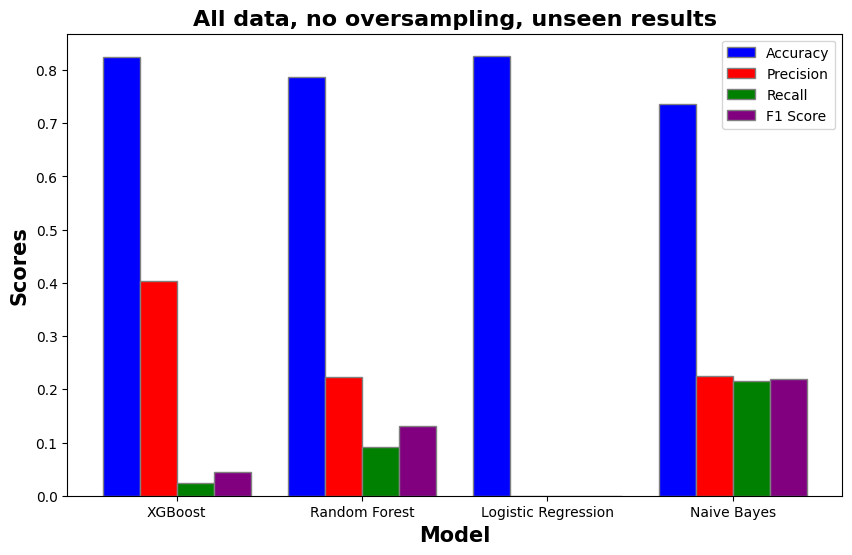

In [ ]:
# data for "All data, no oversampling, unseen"
models = ['XGBoost', 'Random Forest', 'Logistic Regression', 'Naive Bayes']
accuracy_unseen = [0.8249, 0.7872, 0.8268, 0.7359]
precision_unseen = [0.4030, 0.2229, 0.0000, 0.2252]
recall_unseen = [0.0233, 0.0922, 0.0000, 0.2153]
f1_score_unseen = [0.0440, 0.1304, 0.0000, 0.2202]


bar_width = 0.2
r1 = np.arange(len(accuracy_unseen))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Setting up the figure and the axes
fig, ax = plt.subplots(figsize=(10, 6))

# Creating bars for unseen data
ax.bar(r1, accuracy_unseen, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
ax.bar(r2, precision_unseen, color='r', width=bar_width, edgecolor='grey', label='Precision')
ax.bar(r3, recall_unseen, color='g', width=bar_width, edgecolor='grey', label='Recall')
ax.bar(r4, f1_score_unseen, color='purple', width=bar_width, edgecolor='grey', label='F1 Score')

# Adding xticks and labels
ax.set_xlabel('Model', fontweight='bold', fontsize=15)
ax.set_ylabel('Scores', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width*1.5 for r in range(len(accuracy_unseen))])
ax.set_xticklabels(models)

# Adding a legend and a title
ax.set_title('All data, no oversampling, unseen results', fontweight='bold', fontsize=16)
ax.legend()

# Show plot
plt.show()


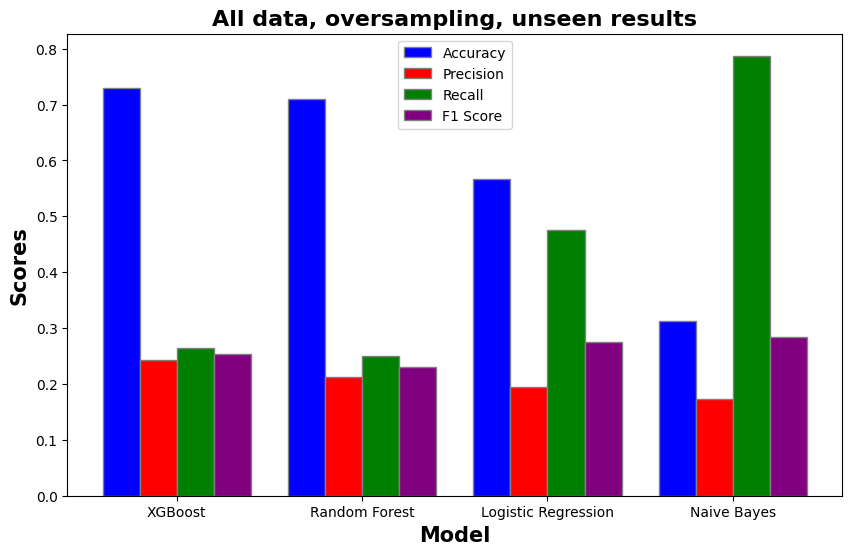

In [ ]:
# Data for "All data, oversampling, unseen"
accuracy_oversampling_unseen = [0.7301, 0.7090, 0.5676, 0.3130]
precision_oversampling_unseen = [0.2427, 0.2121, 0.1940, 0.1733]
recall_oversampling_unseen = [0.2636, 0.2506, 0.4746, 0.7873]
f1_score_oversampling_unseen = [0.2527, 0.2298, 0.2754, 0.2841]

# Setting up the figure and the axes
fig, ax = plt.subplots(figsize=(10, 6))

# Creating bars for oversampling unseen data
ax.bar(r1, accuracy_oversampling_unseen, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
ax.bar(r2, precision_oversampling_unseen, color='r', width=bar_width, edgecolor='grey', label='Precision')
ax.bar(r3, recall_oversampling_unseen, color='g', width=bar_width, edgecolor='grey', label='Recall')
ax.bar(r4, f1_score_oversampling_unseen, color='purple', width=bar_width, edgecolor='grey', label='F1 Score')

# Adding xticks and labels
ax.set_xlabel('Model', fontweight='bold', fontsize=15)
ax.set_ylabel('Scores', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width*1.5 for r in range(len(accuracy_oversampling_unseen))])
ax.set_xticklabels(models)

# Adding a legend and a title
ax.set_title('All data, oversampling, unseen results', fontweight='bold', fontsize=16)
ax.legend()

# Show plot
plt.show()


In [ ]:
# Function to plot each scenario
def plot_scenario(data, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    models = list(data.keys())

    x = np.arange(len(models))  # the label locations
    width = 0.2  # the width of the bars

    # Create a bar for each metric
    for i, metric in enumerate(metrics_labels):
        scores = [data[model][i] for model in models]  # Collect each model's metric score
        ax.bar(x + i*width, scores, width, label=metric)

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(models)
    ax.legend()

    plt.show()


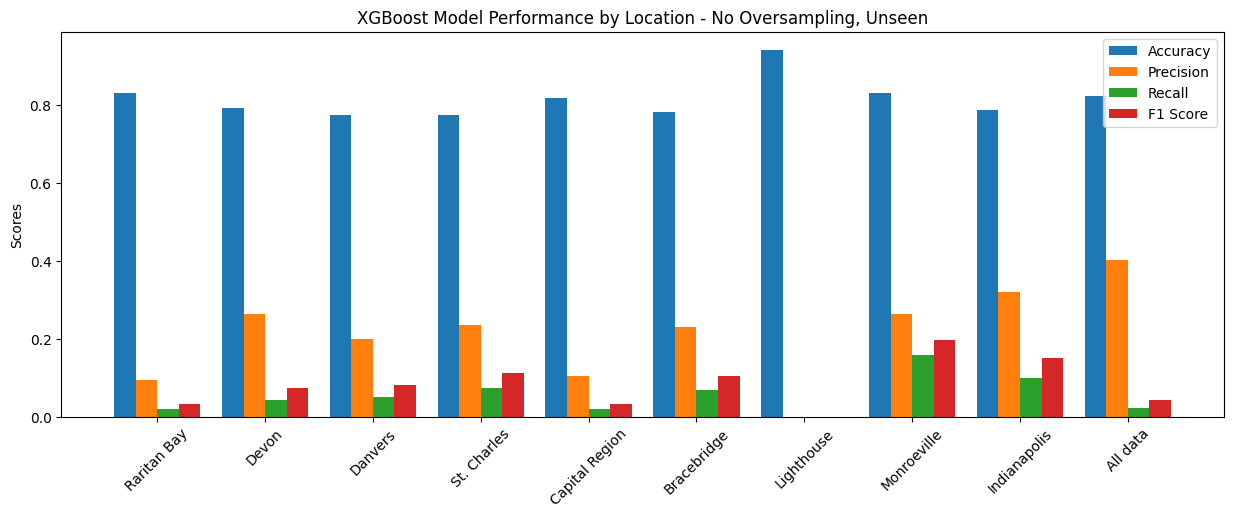

In [ ]:
# Comparing no over sampling for each location in XGBoost model

locations = ['Raritan Bay', 'Devon', 'Danvers', 'St. Charles', 'Capital Region', 'Bracebridge', 'Lighthouse', 'Monroeville', 'Indianapolis', 'All data']
accuracy_no = [0.8326, 0.7946, 0.7744, 0.7764, 0.8190, 0.7827, 0.9417, 0.8320, 0.7876, 0.8249]
precision_no = [0.0952, 0.2647, 0.2000, 0.2353, 0.1053, 0.2308, 0.0000, 0.2632, 0.3200, 0.4030]
recall_no = [0.0211, 0.0439, 0.0517, 0.0748, 0.0198, 0.0682, 0.0000, 0.1587, 0.1000, 0.0233]
f1_score_no = [0.0345, 0.0753, 0.0822, 0.1135, 0.0333, 0.1053, 0.0000, 0.1980, 0.1524, 0.0440]

x = np.arange(len(locations))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width*1.5, accuracy_no, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precision_no, width, label='Precision')
rects3 = ax.bar(x + width/2, recall_no, width, label='Recall')
rects4 = ax.bar(x + width*1.5, f1_score_no, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('XGBoost Model Performance by Location - No Oversampling, Unseen')
ax.set_xticks(x)
ax.set_xticklabels(locations, rotation=45)
ax.legend()

plt.show()


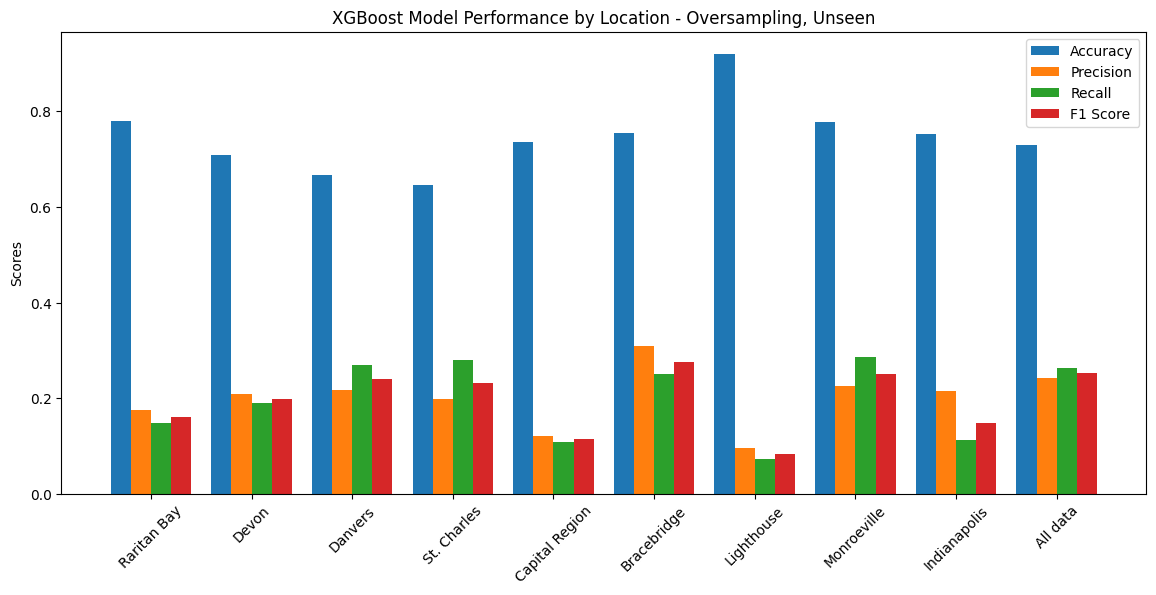

In [ ]:
# Comparing over sampling for each location in XGBoost Model
accuracy_over = [0.7803, 0.7091, 0.6678, 0.6458, 0.7363, 0.7543, 0.9199, 0.7780, 0.7518, 0.7301]
precision_over = [0.1750, 0.2097, 0.2176, 0.1987, 0.1222, 0.3084, 0.0952, 0.2250, 0.2143, 0.2427]
recall_over = [0.1474, 0.1902, 0.2701, 0.2804, 0.1089, 0.2500, 0.0741, 0.2857, 0.1125, 0.2636]
f1_score_over = [0.1600, 0.1995, 0.2410, 0.2326, 0.1152, 0.2762, 0.0833, 0.2517, 0.1475, 0.2527]

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width*1.5, accuracy_over, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precision_over, width, label='Precision')
rects3 = ax.bar(x + width/2, recall_over, width, label='Recall')
rects4 = ax.bar(x + width*1.5, f1_score_over, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('XGBoost Model Performance by Location - Oversampling, Unseen')
ax.set_xticks(x)
ax.set_xticklabels(locations, rotation=45)
ax.legend()

plt.show()


In [ ]:
# Comparing the averages of the location scores with the All data scores for no oversampling